<a href="https://colab.research.google.com/github/noprisigit/mobilenetv2/blob/main/MobileNetV2%20-%20Using%20Albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import itertools
from collections import Counter
import pandas as pd

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# !unzip '/content/drive/MyDrive/iarc-annocerv-master-dataset-balanced-split.zip'

Mounted at /content/drive


In [3]:
# Dataset Path
data_dir = '/content/drive/MyDrive/dataset-swedesh-score'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Count Dataset
def count_dataset(directory):
  class_counts = {}
  total_count = 0

  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if (os.path.isdir(class_path)):
      num_images = len(os.listdir(class_path))
      class_counts[class_name] = num_images
      total_count += num_images

  return class_counts, total_count

total_images, class_distribution = count_dataset(train_dir)
print(f'Total Images Training: {total_images}')
print('Class Distribution Training:', class_distribution)

total_images, class_distribution = count_dataset(val_dir)
print(f'Total Images Validation: {total_images}')
print('Class Distribution Validation:', class_distribution)

Total Images Training: {'CIN 2': 1380, 'CIN 3': 1900, 'CIN 1': 3140, 'Normal': 1100}
Class Distribution Training: 7520
Total Images Validation: {'CIN 2': 30, 'CIN 3': 43, 'Normal': 25, 'CIN 1': 68}
Class Distribution Validation: 166


In [4]:
def image_CALHE(image):
    # Ensure the image is in the correct data type before CLAHE
    image = image.astype(np.uint8)  # Convert to 8-bit if it's not already

    # Thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    # Apply CLAHE to the original grayscale image
    clahe_img = clahe.apply(gray)

    # Clip and convert to uint8 after CLAHE application
    clahe_img = np.clip(clahe_img + 30, 0, 255).astype(np.uint8)

    cl1 = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)

    # Convert the output to float32 to avoid type mismatch during rescaling
    cl1 = cl1.astype(np.float32)

    return cl1

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentasi data untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # zoom_range=0.2,
    # rotation_range=70,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=image_CALHE
)
# train_datagen = ImageDataGenerator(rescale=1./255)

# Hanya rescale untuk validation dan test set
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=image_CALHE
)

# Data generator untuk train, validation, dan test set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',

    shuffle=False,
)

Found 7520 images belonging to 4 classes.
Found 166 images belonging to 4 classes.


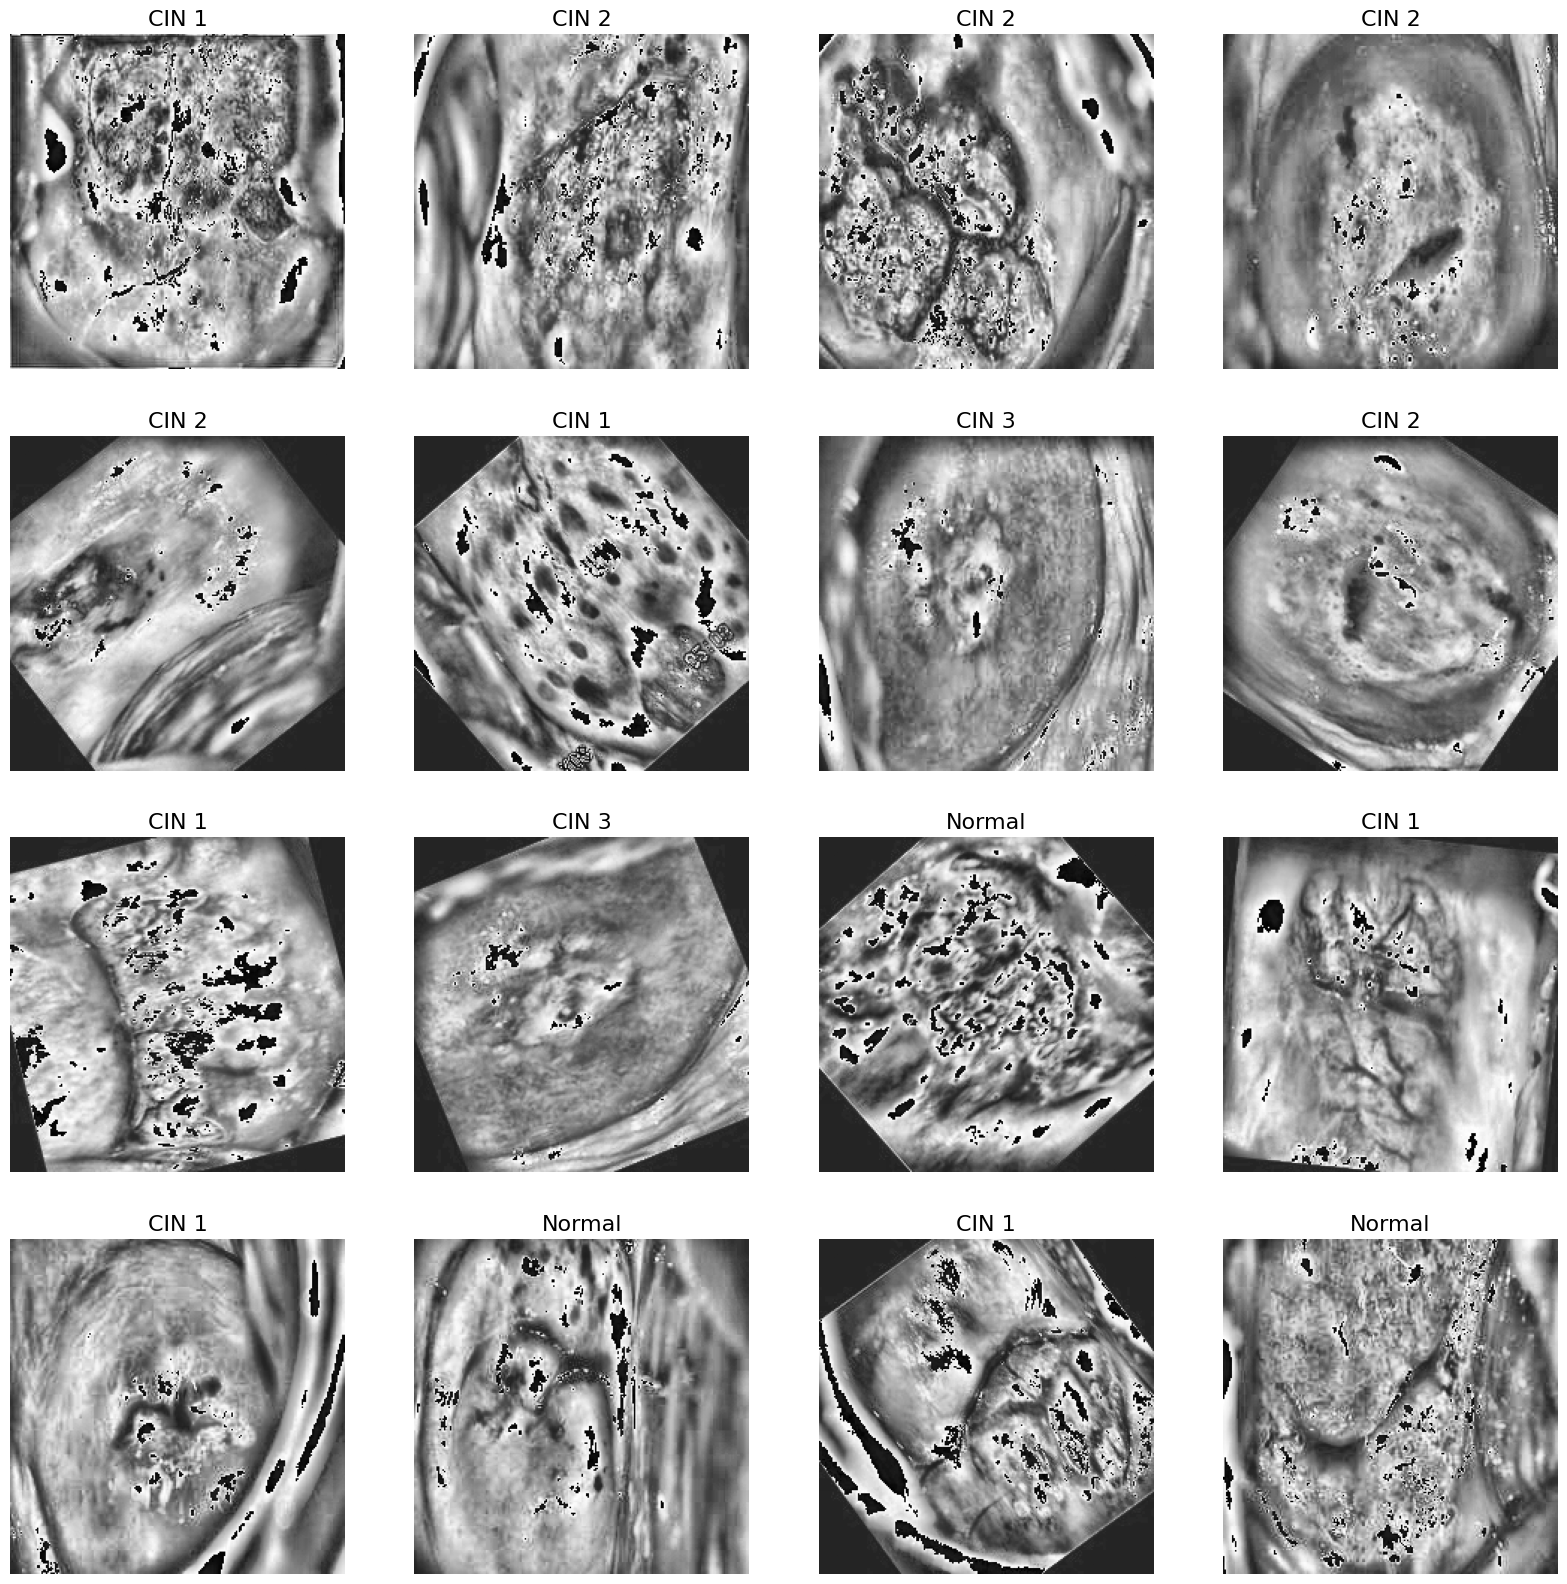

In [8]:
# Display Sample Images
# def plot_sample_images(generator):
#   class_names = list(generator.class_indices.keys())
#   plt.figure(figsize=(10, 5))

#   for i in range(6):
#     img, label = next(generator)
#     plt.subplot(2, 3, i + 1)
#     plt.imshow(img[0])
#     plt.title(class_names[np.argmax(label[0])])
#     plt.axis('off')

#   plt.show()

# plot_sample_images(train_generator)
gen_dict = train_generator.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_generator)
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] # / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 16)
    plt.axis('off')
plt.show();

In [9]:
# Hitung Class Weighs

class_indices = train_generator.class_indices
print("Class indices:", class_indices)

labels = train_generator.classes  # array of class index per sample
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class indices: {'CIN 1': 0, 'CIN 2': 1, 'CIN 3': 2, 'Normal': 3}
Class weights: {0: np.float64(0.5987261146496815), 1: np.float64(1.3623188405797102), 2: np.float64(0.9894736842105263), 3: np.float64(1.709090909090909)}


In [10]:
# Load MobileNetV2 dengan weights 'imagenet' dan tanpa top layer
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan custom top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

# Bangun model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,889,668 (18.65 MB)

 Trainable params: 2,631,684 (10.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

callbacks = [early_stop]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    # class_weight=class_weights,
    # callbacks=callbacks
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2235s 9s/step - accuracy: 0.4310 - loss: 2.8162 - val_accuracy: 0.5000 - val_loss: 1.8025
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.5966 - loss: 1.4983 - val_accuracy: 0.4578 - val_loss: 1.6120
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.6519 - loss: 1.2130 - val_accuracy: 0.5482 - val_loss: 1.5496
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.6795 - loss: 1.0921 - val_accuracy: 0.5181 - val_loss: 1.5783
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.7281 - loss: 0.9822 - val_accuracy: 0.5060 - val_loss: 1.6154
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.7543 - loss: 0.9136 - val_accuracy: 0.5060 - val_loss: 1.6303
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.7627 - loss: 0.8696 - val_accuracy: 0.4759 - val_loss: 1.6325
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.7657 - 

235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.9673 - loss: 0.3630
Train Accuracy: 0.9681
Train Loss: 0.3617
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6470 - loss: 1.3777
Val Accuracy: 0.5663
Val Loss: 1.6949
🏆 Best Epoch: 82
✅ Best Train Acc: 0.8673
✅ Best Val Acc: 0.5964
📉 Best Train Loss: 0.5765
📉 Best Val Loss: 1.8168
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 734ms/step
              precision    recall  f1-score   support

      Normal       0.54      0.82      0.65        68
        CIN1       0.46      0.20      0.28        30
        CIN2       0.62      0.60      0.61        43
        CIN3       0.75      0.24      0.36        25

    accuracy                           0.57       166
   macro avg       0.59      0.47      0.48       166
weighted avg       0.58      0.57      0.53       166



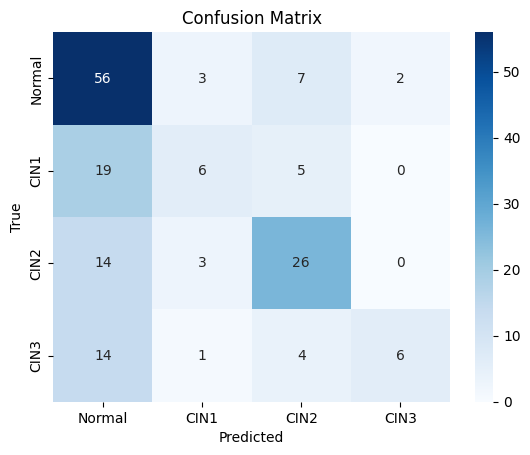

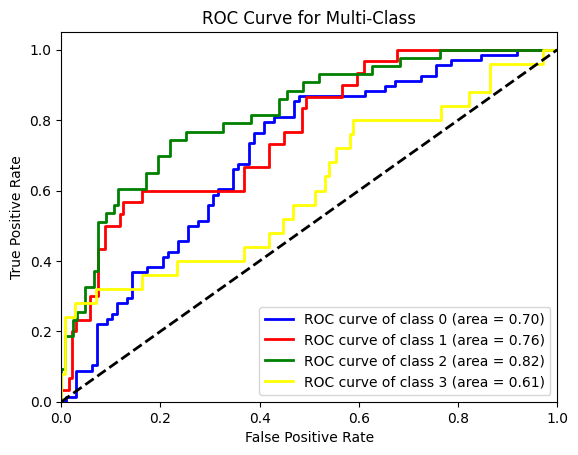

In [13]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(train_generator)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Train Loss: {train_loss:.4f}')

val_loss, val_acc = model.evaluate(val_generator)
print(f'Val Accuracy: {val_acc:.4f}')
print(f'Val Loss: {val_loss:.4f}')

# === EVALUASI: NILAI TERBAIK ===
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"🏆 Best Epoch: {best_epoch+1}")
print(f"✅ Best Train Acc: {history.history['accuracy'][best_epoch]:.4f}")
print(f"✅ Best Val Acc: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"📉 Best Train Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"📉 Best Val Loss: {history.history['val_loss'][best_epoch]:.4f}")

# Predict the test set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'CIN1', 'CIN2', 'CIN3']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'CIN1', 'CIN2', 'CIN3'], yticklabels=['Normal', 'CIN1', 'CIN2', 'CIN3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'yellow']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()

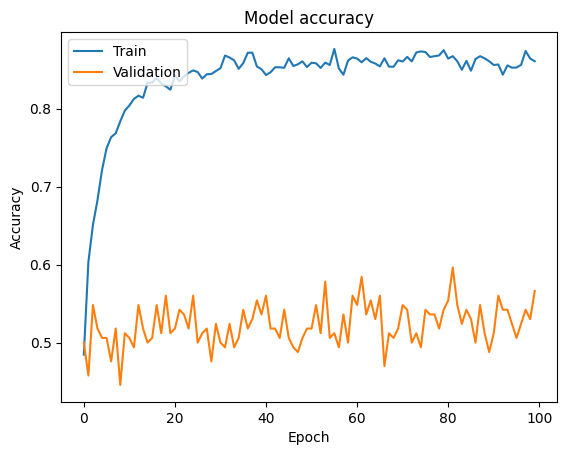

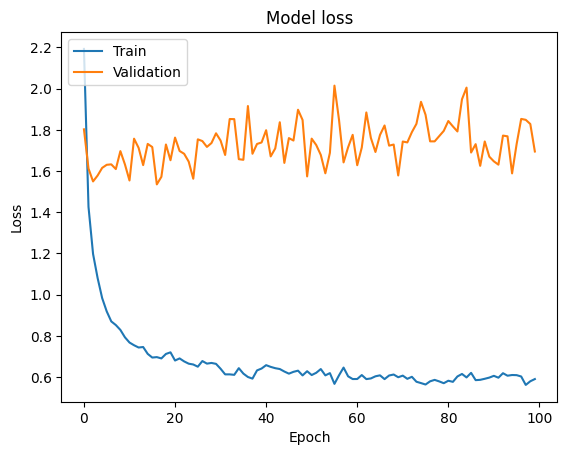

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Calculate sensitivity (recall), precision, and F1-score
sensitivity = recall_score(y_true, y_pred_classes, average=None)
precision = precision_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Calculate specificity
specificity = []
for i in range(3):
    tn = np.sum((y_true != i) & (y_pred_classes != i))
    fp = np.sum((y_true != i) & (y_pred_classes == i))
    specificity.append(tn / (tn + fp))

print(f'Sensitivity: {sensitivity}')
print(f'Precision: {precision}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')

Sensitivity: [0.82352941 0.2        0.60465116 0.24      ]
Precision: [0.54368932 0.46153846 0.61904762 0.75      ]
F1-Score: [0.65497076 0.27906977 0.61176471 0.36363636]
Specificity: [np.float64(0.5204081632653061), np.float64(0.9485294117647058), np.float64(0.8699186991869918)]


In [16]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import cv2

# # Fungsi untuk membuat Grad-CAM
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(predictions[0])
#         class_channel = predictions[:, pred_index]

#     grads = tape.gradient(class_channel, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0]
#     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# # Fungsi untuk tampilkan Grad-CAM
# def show_gradcam(image_path, model, last_conv_layer_name='Conv_1'):
#     img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (224, 224))
#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     superimposed_img = heatmap_color * 0.4 + img

#     plt.figure(figsize=(8, 8))
#     plt.imshow(cv2.cvtColor(superimposed_img.astype("uint8"), cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.title('Grad-CAM')
#     plt.show()



In [17]:

# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from tensorflow.keras.preprocessing import image

# def compute_cam(model, img_path, target_size=(224, 224), class_idx=None):
#     # Ambil image dan preprocess
#     img = image.load_img(img_path, target_size=target_size)
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

#     # Buat model tanpa softmax
#     cam_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer("Conv_1").output, model.output])
#     conv_outputs, predictions = cam_model.predict(img_array)

#     if class_idx is None:
#         class_idx = np.argmax(predictions[0])

#     # Ambil bobot dari FC layer terakhir
#     final_dense = model.get_layer(index=-1)  # Dense layer terakhir
#     weights = final_dense.get_weights()[0]  # shape: (num_filters, num_classes)

#     # Dot product antara feature map dan bobot class tertentu
#     cam = np.dot(conv_outputs[0], weights[:, class_idx])

#     # Normalisasi
#     cam = cv2.resize(cam, target_size)
#     cam = np.maximum(cam, 0)
#     cam = cam / cam.max()

#     # Overlay CAM
#     heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, target_size)
#     overlay = heatmap * 0.4 + img

#     # Tampilkan
#     plt.figure(figsize=(6,6))
#     plt.imshow(cv2.cvtColor(overlay.astype("uint8"), cv2.COLOR_BGR2RGB))
#     plt.title(f'CAM untuk kelas {class_idx}')
#     plt.axis('off')
#     plt.show()

In [18]:
# x_batch, y_batch = next(train_generator)  # ambil batch pertama

# # Simpan 1 gambar per kelas
# class_indices = np.argmax(y_batch, axis=1)  # ubah one-hot ke label

# saved_images = {}
# for idx, label in enumerate(class_indices):
#     if label not in saved_images:
#         img = x_batch[idx]
#         img_path = f'class_{label}_sample.jpg'
#         tf.keras.preprocessing.image.save_img(img_path, img)
#         saved_images[label] = img_path

#     if len(saved_images) == 3:  # kalau sudah semua kelas ditemukan
#         break

# for label, img_path in saved_images.items():
#     print(f"\nGrad-CAM dan CAM untuk Kelas: {label}")

#     print("Grad-CAM:")
#     show_gradcam(img_path, model)

#     # print("CAM:")
#     # compute_cam(model, img_path, class_idx=label)

In [19]:
# x_batch, y_batch = next(val_generator)  # ambil batch pertama

# # Simpan 1 gambar per kelas
# class_indices = np.argmax(y_batch, axis=1)  # ubah one-hot ke label

# saved_images = {}
# for idx, label in enumerate(class_indices):
#     if label not in saved_images:
#         img = x_batch[idx]
#         img_path = f'class_{label}_sample.jpg'
#         tf.keras.preprocessing.image.save_img(img_path, img)
#         saved_images[label] = img_path

#     if len(saved_images) == 3:  # kalau sudah semua kelas ditemukan
#         break

# for label, img_path in saved_images.items():
#     print(f"\nGrad-CAM dan CAM untuk Kelas: {label}")

#     print("Grad-CAM:")
#     show_gradcam(img_path, model)

#     # print("CAM:")
#     # compute_cam(model, img_path, class_idx=label)